<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Réaliser un embedding des conditions en amont de l'apprentissage du CVAE pour contrôler l'information latente ? </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Lorenzo HERMEZ  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  15 avril 2022  </b>  </font> </center>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

2022-04-25 13:42:28.298048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 13:42:28.298093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#root git folder 
name_model="Cvae"
path_second_folder = %pwd #"/home/goubetcle/Documents/Git/VAE/"
save_path = os.path.join(path_second_folder,"Results/Unbiaised")#"/home/goubetcle/Documents/VAE/"
log_dir_model=os.path.join(save_path,"logs")
gifs_path = os.path.join(path_second_folder,"Gifs/Unbiaised")
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [4]:
import importlib

sys.path.append(path_second_folder+'/src')

#import models, loss_class, params_class,AE_blocks,metrics
from src.models import *
#importlib.reload(models)
from src.loss_class import *
#importlib.reload(loss_class)
from src.params_class import *
#importlib.reload(params_class)
import src.AE_blocks
#importlib.reload(AE_blocks)
from src.metrics import *
#importlib.reload(metrics)
from src.utils import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2020. 

In [5]:
# Load dataframe
dataset_csv = os.path.join('data', "dataset_2012_2020.csv")
df_data = pd.read_csv(dataset_csv, sep=";",)
df_data.utc_datetime = pd.to_datetime(df_data.utc_datetime, utc=True)

#Visualize data frame head
df_data.tail(5)

,utc_datetime,Consommation,prevision_j,prevision_j-1,prevision_neb,prevision_temp,is_holidays
157819,2020-12-31 21:30:00+00:00,64423.0,63700.0,64400.0,3.400764,2.328079,0.0
157820,2020-12-31 22:00:00+00:00,63505.0,63200.0,63800.0,3.479000,2.164250,0.0
157821,2020-12-31 22:30:00+00:00,64331.0,65200.0,65800.0,3.490986,2.029558,0.0
157822,2020-12-31 23:00:00+00:00,66853.0,67000.0,67500.0,3.369000,1.950550,0.0
157823,2020-12-31 23:30:00+00:00,66750.0,67200.0,67600.0,3.045322,1.953771,0.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, tout ce qui va être inséré comme entrées du modèle est ici normalisé sur l'ensemble des mesures, puis mis en profils journaliers.

Notre jeu d'entrainement et pour référence est le jeu de données 2012-2018.

In [6]:
ds = pd.DataFrame({"days" : df_data.utc_datetime.dt.date, "minute":df_data.utc_datetime.dt.minute+60*df_data.utc_datetime.dt.hour})

df_conso, df_temp, df_prevision = make_chronics(df=pd.concat([df_data, ds], axis=1),
                                               toshape_columns=["Consommation", "prevision_temp", "prevision_j-1"],
                                               pivot_indexcol="days", pivot_columncol="minute")

df_conso.head()

minute,0,30,60,90,120,150,180,210,240,270,...,1140,1170,1200,1230,1260,1290,1320,1350,1380,1410
days,,,,,,,,,,,,,,,,,,,,,
2012-01-01,58315.0,58315.0,56231.0,56075.0,55532.0,54911.0,52496.0,50664.0,49161.0,47596.0,...,57333.0,57786.0,57752.0,56946.0,56054.0,54975.0,53890.0,54348.0,56577.0,55634.0
2012-01-02,55164.0,53643.0,51404.0,50842.0,50399.0,50113.0,48201.0,47182.0,46306.0,46294.0,...,73263.0,72615.0,71079.0,69050.0,67435.0,65332.0,63756.0,64030.0,65929.0,64902.0
2012-01-03,64600.0,63033.0,60533.0,60426.0,60104.0,59861.0,57915.0,56691.0,55743.0,55656.0,...,76698.0,75660.0,73535.0,71275.0,69189.0,66829.0,64861.0,64898.0,66939.0,65479.0
2012-01-04,65081.0,63129.0,60564.0,60194.0,59709.0,59353.0,57569.0,56545.0,55655.0,55628.0,...,78337.0,77173.0,75281.0,72985.0,70927.0,68726.0,66808.0,66878.0,68550.0,67376.0
2012-01-05,67042.0,65123.0,62447.0,62331.0,61889.0,61501.0,59574.0,58245.0,57258.0,56923.0,...,78351.0,76928.0,74868.0,72432.0,70197.0,68036.0,66269.0,66070.0,68169.0,66910.0


In [7]:
df_conso, conso_scaler = apply_scaler(df_data, column="Consommation", df_chronic=df_conso,
                                      reference_window=df_data.utc_datetime.dt.year <=2018)
df_conso.head()

minute,0,30,60,90,120,150,180,210,240,270,...,1140,1170,1200,1230,1260,1290,1320,1350,1380,1410
days,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.306926,0.306926,0.135886,0.123082,0.078516,0.027549,-0.170658,-0.321017,-0.444373,-0.572818,...,0.226330,0.263510,0.260719,0.194568,0.121359,0.032801,-0.056248,-0.018659,0.164283,0.086888
2012-01-02,0.048313,-0.076520,-0.260282,-0.306408,-0.342766,-0.366239,-0.523163,-0.606796,-0.678692,-0.679677,...,1.533758,1.480575,1.354510,1.187984,1.055435,0.882835,0.753487,0.775975,0.931833,0.847543
2012-01-03,0.822757,0.694148,0.488965,0.480183,0.453756,0.433812,0.274097,0.173639,0.095834,0.088693,...,1.815680,1.730488,1.556082,1.370597,1.199392,1.005699,0.844178,0.847215,1.014727,0.894900
2012-01-04,0.862234,0.702027,0.491509,0.461142,0.421337,0.392118,0.245700,0.161657,0.088611,0.086395,...,1.950198,1.854665,1.699382,1.510942,1.342035,1.161392,1.003975,1.009720,1.146947,1.050593
2012-01-05,1.023180,0.865682,0.646053,0.636533,0.600256,0.568412,0.410257,0.301181,0.220175,0.192680,...,1.951348,1.834557,1.665486,1.465555,1.282122,1.104761,0.959738,0.943405,1.115677,1.012347


'df_conso' est constitué des profils journaliers de consommation d'lélectricité que l'on va mettre en entrée de notre VAE

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [8]:
#importation des données calendaires
df_calendar = make_df_calendar(pd.DataFrame({"ds" : pd.to_datetime(np.asarray(df_conso.index))}))

df_holidays = pd.concat([df_data[["is_holidays"]],pd.DataFrame({"ds" : pd.to_datetime(ds.days.values)})], axis=1).drop_duplicates(
                                               subset="ds").reset_index(drop= True)

df_calendar = df_calendar.merge(df_holidays, on="ds", how="left").rename(columns={"is_holidays":"is_holiday_day"})

df_calendar.head(5)

,ds,month,weekday,is_weekend,year,is_holiday_day
0,2012-01-01,1,6,1,2012,1.0
1,2012-01-02,1,0,0,2012,0.0
2,2012-01-03,1,1,0,2012,0.0
3,2012-01-04,1,2,0,2012,0.0
4,2012-01-05,1,3,0,2012,0.0


In [9]:
#explicit the potential bridge days taken as extended holidays
day_hol = df_calendar[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

df_calendar['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [10]:
calendar_factors = ["weekday", "is_weekend", "month", "is_holiday_day"]
factors = df_calendar[calendar_factors].copy()
factorDesc = {ff : 'category' for ff in calendar_factors}

temperatureMean= df_temp.mean(axis=1).values.reshape(-1,1)
factorMatrix = np.c_[factors.values,temperatureMean]
factorDesc['temperature']='regressor'


# Tools to evaluate the representations

In [11]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

def prez_2D_holidays(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c=temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    index = factorMatrix[:,-2]==1
    plt.scatter(x=proj[index,0], y=proj[index,1], color='yellow', marker='*',s=450)
    
def prez_3D(x_encoded, factorMatrix, temperatureMean):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        if self.VAE_params.model_params.with_embedding :
            assert(len(self.VAE_params.model_params.cond_dims) + 1 == len(self.VAE_params.model_params.emb_dims))

        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [13]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=df_conso.shape[0]
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [14]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(scaler_conso.inverse_transform(x), label = 'truth')
    plt.plot(scaler_conso.inverse_transform(x_hat), '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE ou CVAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)
- les dimensions de notre embedding des conditions dans le cas dans CVAE

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [32]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

On va mettre en forme ici les facteurs sur lesquels on va rendre la représentation latente agnostique. Attention à normaliser les variables quantitatives et à one-hot encoder les variables catégorielles. 

In [33]:
#on va conditionner sur les profils de température et le mois
calendar_cond = ['month']
condtovae_dims = []
condarray=[]

df_temp, _ = apply_scaler(df_data, column="prevision_temp", df_chronic=df_temp,
                                      reference_window=None)

condarray.append(df_temp.values)
condtovae_dims.append(condarray[-1].shape[1])

for cc in calendar_cond:
    condarray.append(pd.get_dummies(df_calendar[cc], prefix=cc).values)
    condtovae_dims.append(condarray[-1].shape[1])



In [35]:
cond_inputs = np.c_[condarray[0], condarray[1]]

In [30]:
# définition des hyperparamètres 

weights_dict_cond = {}



In [211]:
# paramètres de l'autoencodeur
z_dim = 2 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[60,36,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[60,36,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = cond_inputs.shape[1]

The random seed has been set to 4796
---------- Parameters init with beta=0.3 and gamma=200 ----------
Default values for model architecture are:
with_embedding  :=  False
emb_dims  :=  []
kernel_initializer  :=  glorot_uniform
bias_initializer  :=  glorot_uniform
reparametrize  :=  GaussianSampling
intel_function  :=  Intel_PCA
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
embedding_type  :=  EmbeddingBlock_model
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003
Model: "encoder"
_______________________________________________________________________________________________

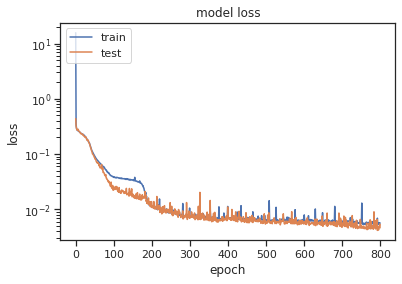

## MODEL SAVED ##
Training duration: 0:05:05.538980


In [212]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

name_model = 'cond_vae'
start_time = datetime.now()
seed = 4796
beta = 0.3
gamma = 200

# Set different seed
np.random.seed(seed)
print(f"The random seed has been set to {seed}")

print(f"---------- Parameters init with beta={beta} and gamma={gamma} ----------")
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)
vae_params.set_model_params()
vae_params.set_training_params()

vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.latent_dims = z_dim
vae_params.model_params.input_dims = cond_inputs.shape[1]
vae_params.model_params.output_dims = cond_inputs.shape[1]
vae_params.model_params.encoder_type = 'NNBlock_model'
vae_params.model_params.decoder_type = 'InceptionBlock_model'
loss_weights = {"recon_loss" : 1}
vae_loss = VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 3e-4

cond_vae=CVAE(vae_params)
cond_vae.build_model(vae_params)

# Callbacks
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
weight_callback_cond = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs: weights_dict_cond.update({epoch:cond_vae.encoder.get_weights()}))

train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019
input_cvae = [cond_inputs[train_set,:]]
output_cvae = cond_inputs[train_set,:]

print(f"---------- Model training ----------")
cond_vae.train(input_cvae, output_cvae, epochs= epochs, verbose=1,
        batch_size=batch_size, callbacks=[earl_stop, weight_callback_cond])

end_time = datetime.now()
print('Training duration: {}'.format(end_time - start_time))

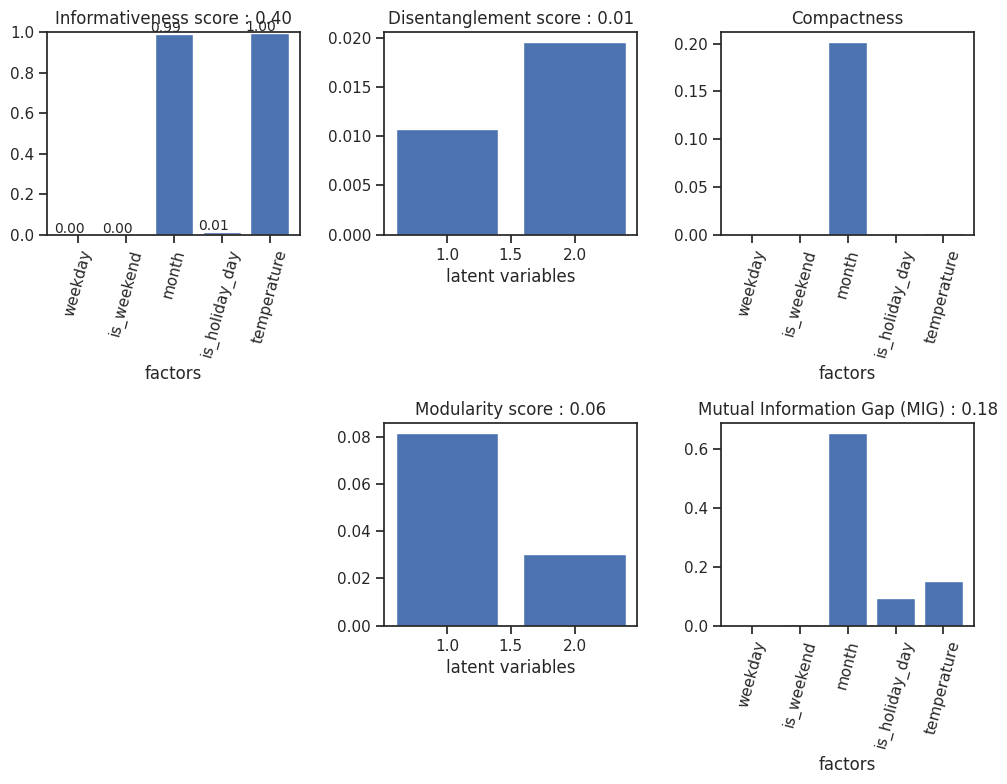

In [214]:
cond_encoded = cond_vae.encoder.predict(cond_inputs[train_set,:])[0]
model_eval, importanceMatrix =evaluate_latent_code(cond_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, 2, factorDesc)

In [222]:
import plotly.express as px
fig = px.scatter(cond_encoded, x=0, y=1, color=factorMatrix[train_set,2])
fig.show()

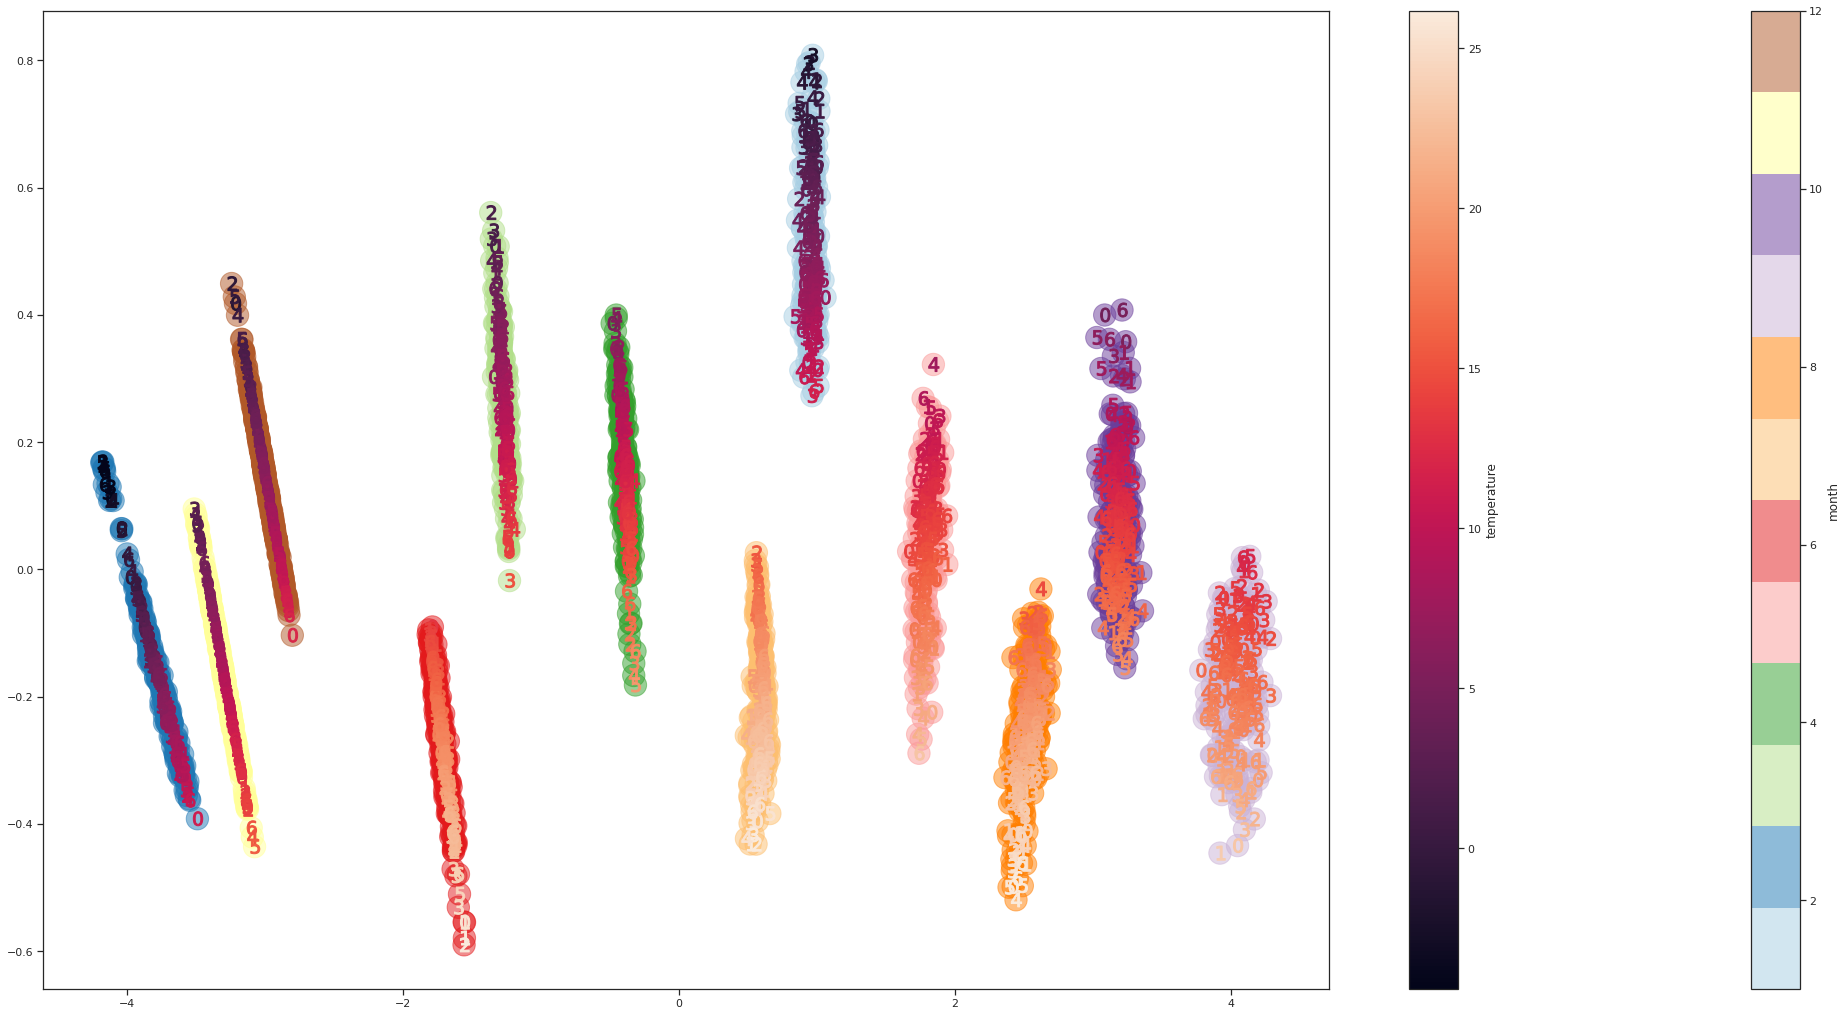

In [216]:
prez_2D(cond_encoded, factorMatrix[train_set,:], temperatureMean[train_set,:])

In [123]:
# définition des hyperparamètres 

weights_dict_enc = {}
weights_dict_dec = {}

The random seed has been set to 4796
---------- Parameters init with beta=3 and gamma=100 ----------
Default values for model architecture are:
with_embedding  :=  False
emb_dims  :=  []
kernel_initializer  :=  glorot_uniform
bias_initializer  :=  glorot_uniform
reparametrize  :=  GaussianSampling
intel_function  :=  Intel_PCA
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
embedding_type  :=  EmbeddingBlock_model
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003
Model: "encoder"
_________________________________________________________________________________________________

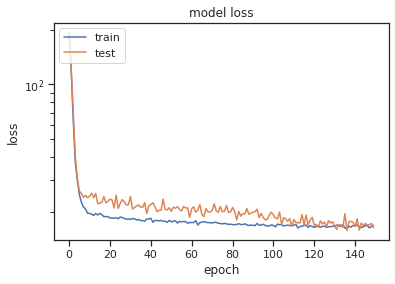

## MODEL SAVED ##
Training duration: 0:01:10.865128


In [223]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

name_model = 'cvae_2nd'
start_time = datetime.now()
seed = 4796
beta = 3
gamma = 100

# Set different seed
np.random.seed(seed)
print(f"The random seed has been set to {seed}")

print(f"---------- Parameters init with beta={beta} and gamma={gamma} ----------")
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)
vae_params.set_model_params()
vae_params.set_training_params()

vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.latent_dims = 4
vae_params.model_params.cond_dims = [cond_encoded.shape[1]]
vae_params.model_params.encoder_type = 'NNBlockCond_model'
vae_params.model_params.decoder_type = 'NNBlockCond_model'

loss_weights = {"recon_loss" : 1,"kl_loss" : beta, "info_loss" : gamma}
vae_loss = VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 3e-4

cvae2=CVAE(vae_params)
cvae2.build_model(vae_params)

# Callbacks
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
weight_callback_enc = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs: weights_dict_enc.update({epoch:cvae2.encoder.get_weights()}))
weight_callback_dec = tf.keras.callbacks.LambdaCallback \
( on_epoch_end=lambda epoch, logs: weights_dict_dec.update({epoch:cvae2.decoder.get_weights()}))

train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019
input_cvae = [df_conso.values[train_set,:]] + [cond_encoded]
output_cvae = df_conso.values[train_set,:]

print(f"---------- Model training ----------")
cvae2.train(input_cvae, output_cvae, epochs= 150, verbose=1,
        batch_size=batch_size, callbacks=[earl_stop, weight_callback_enc, weight_callback_dec, weight_callback_cond])

end_time = datetime.now()
print('Training duration: {}'.format(end_time - start_time))

## Evaluer l'importance et la qualité des embeggings appris

Nous allons voir:
- l'importance portée par des variables dans la représentation latente
- l'importance portée par des variables dans l'embedding conditionnel

Nous nous appuyons pour cela sur des score d'information, de démêlement, de compacité et de modularité

Nous devrions constater que des variables importante dans l'embedding conditionnel ne le sont plus dans la représentation latente: elles ont été factorisées

In [224]:
x_encoded = cvae2.encoder.predict(input_cvae)[0]

In [225]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire

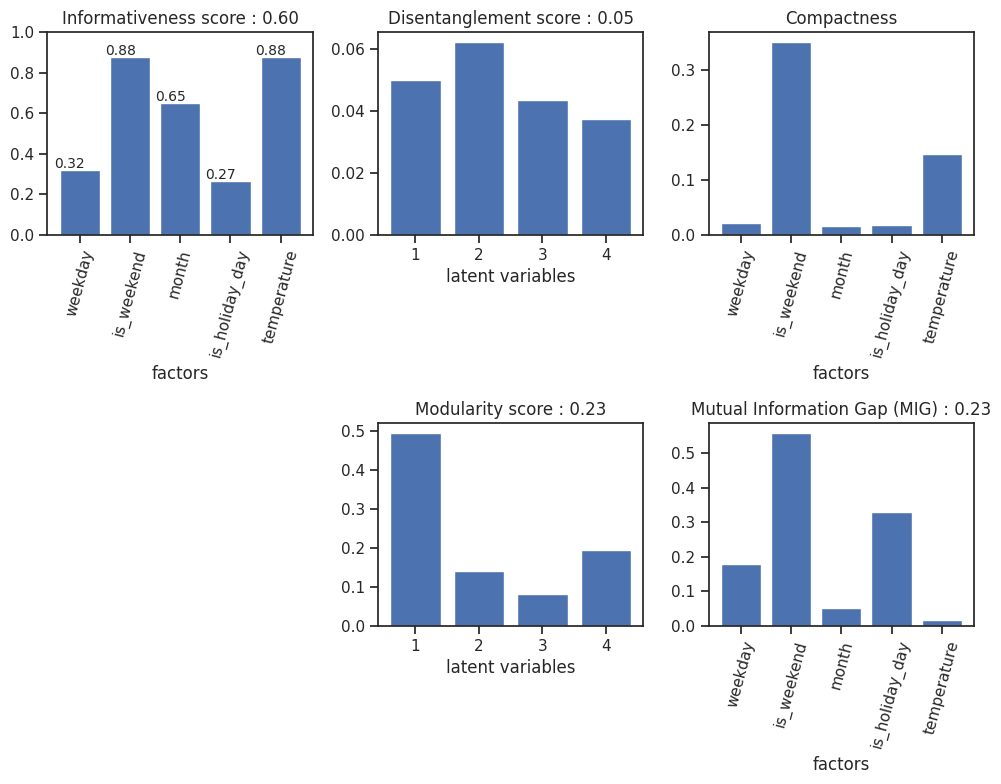

In [226]:
display_evaluation_latent_code(model_eval, 4, factorDesc)

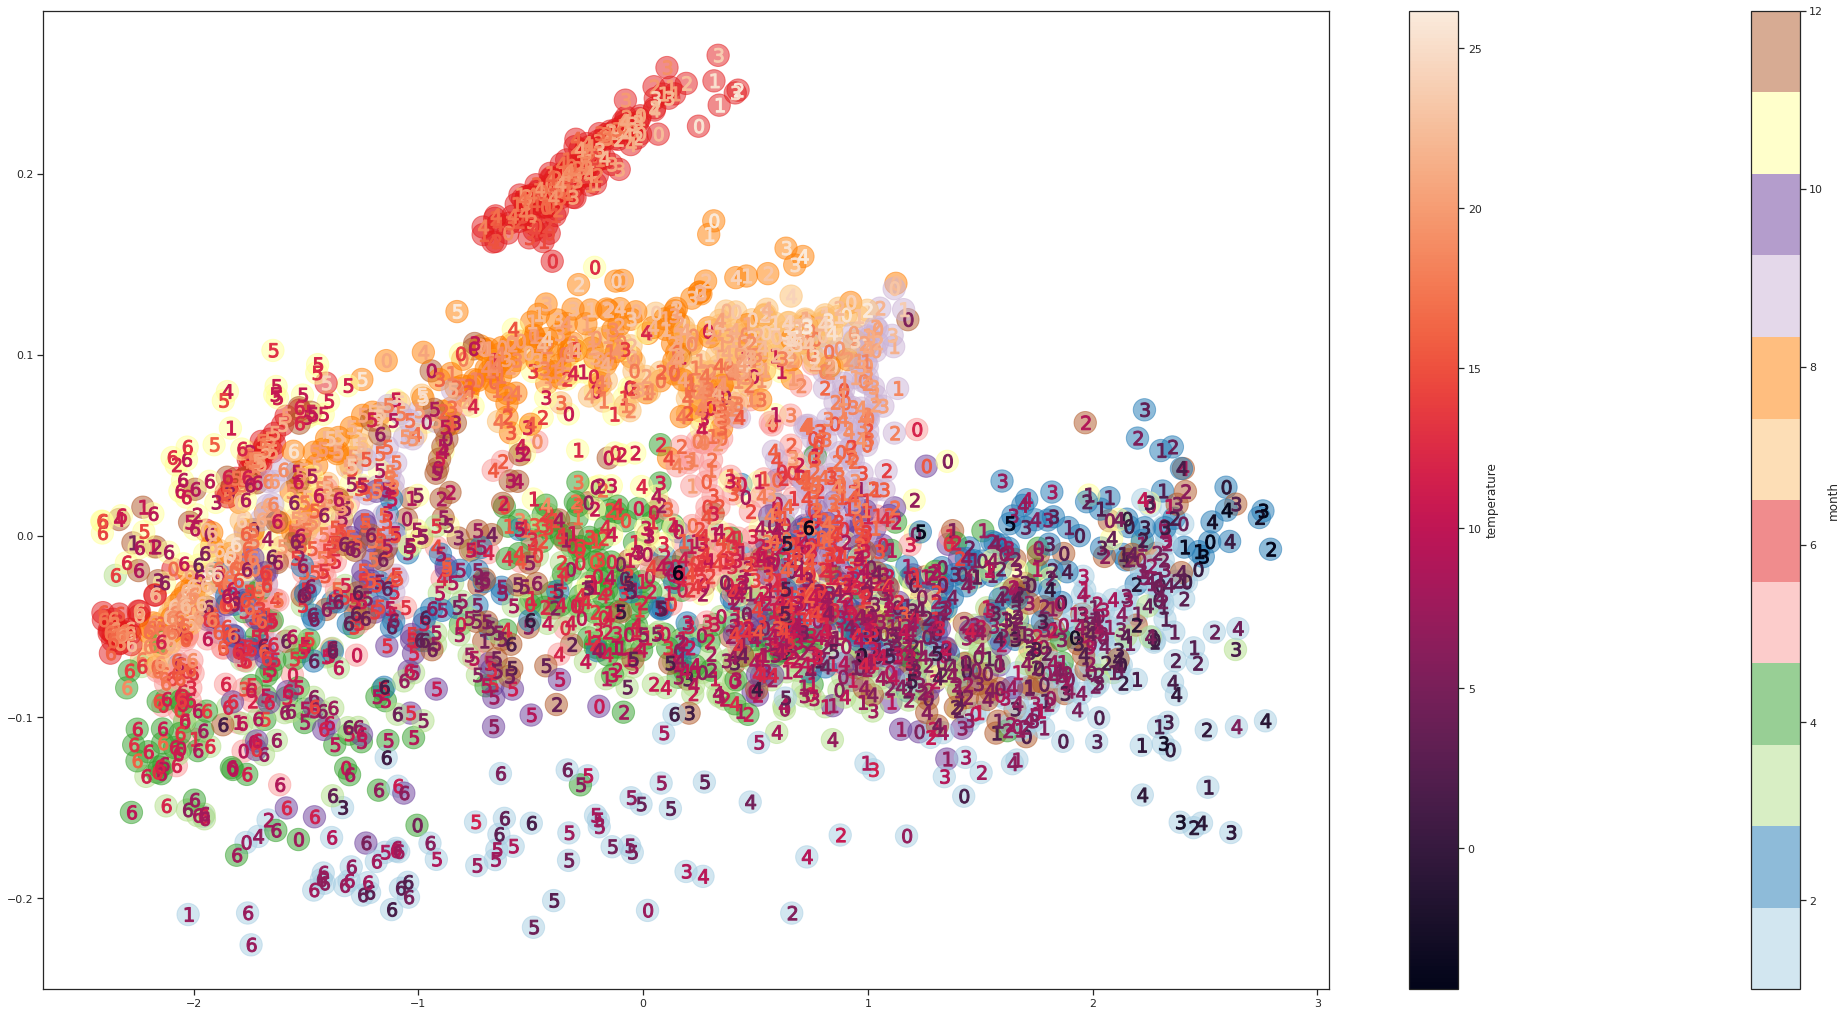

In [227]:
prez_2D(x_encoded, factorMatrix[train_set,:], temperatureMean[train_set])


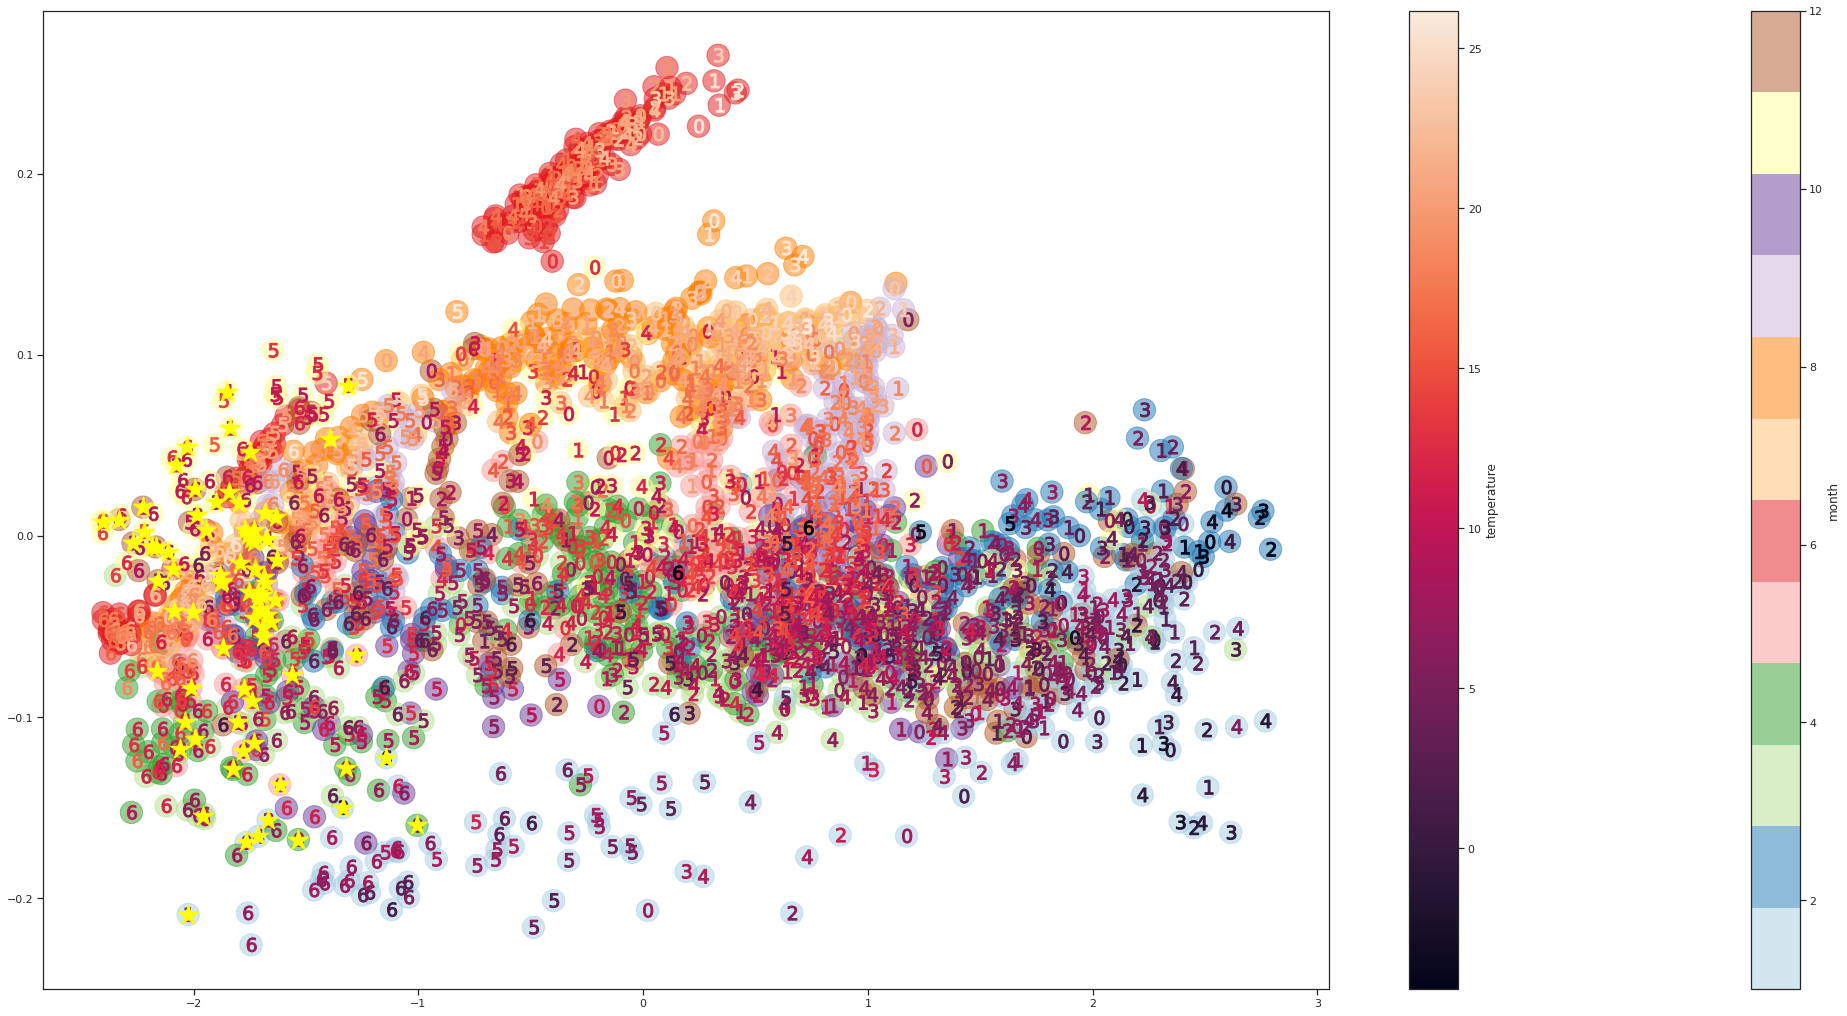

In [228]:
prez_2D_holidays(x_encoded, factorMatrix[train_set,:], temperatureMean[train_set])

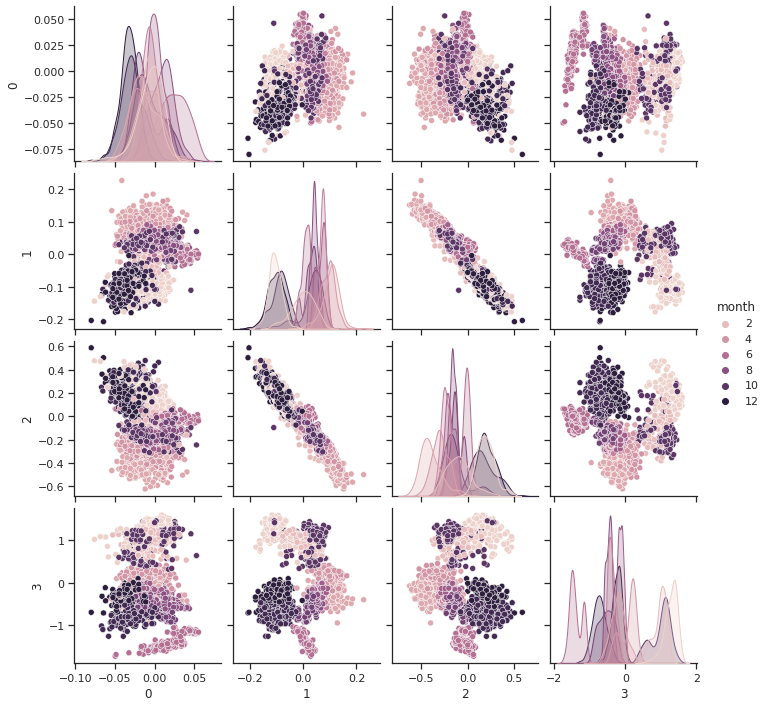

In [84]:
data = {i: x_encoded[:,i] for i in range(x_encoded.shape[1])}
data['month'] = df_calendar.month[train_set]
z=pd.DataFrame(data=data)

import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(z, hue='month')

## Visualisation des poids au cours de l'apprentissage

In [85]:
def normalize_columns_weights(weights_dict):
    from sklearn.preprocessing import MinMaxScaler

    scaled_dict = {}
    for i in weights_dict.keys():
        scaled_dict[i] = []
        for l in range(len(weights_dict[i])):
            tmp = weights_dict[i][l]
            if len(weights_dict[i][l].shape)==1:
                tmp = weights_dict[i][l].reshape(-1,1)
            sc = MinMaxScaler((-1,1))
            scaled_dict[i].append(sc.fit_transform(tmp))
    return scaled_dict

In [86]:
def weights_heatmap(weights_dict, epoch, layer, normalize =True):
    assert layer%2==0, 'Make sure you chose a weights matrix and not the biais vector'
    t = 1/(np.max(weights_dict[epoch][layer])-np.min(weights_dict[epoch][layer])) * (weights_dict[epoch][layer] - np.min(weights_dict[epoch][layer]))
    if normalize:
        sn.heatmap(t, cmap='coolwarm')
    else: 
        sn.heatmap(weights_dict[epoch][layer], cmap = 'coolwarm')
    plt.show()

In [87]:
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(array, cmap_name='coolwarm', vmin=-1, vmax=1):
    
    array = np.asarray(array)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name) 
    if len(array.shape)==1:
        rgb = np.array(cmap(norm(array))[:,:3]) 
    else:
        rgb = np.array(cmap(norm(array))[:,:,:3])  # will return rgba, we take only first 3 so we get rgb
    return rgb

In [88]:
def create_colored_dict(weights_dict_enc):
    colored_dict_enc = {}
    epochs = len(weights_dict_enc.keys())
    for i in range(epochs):
        colored_dict_enc[i] = []
        for l in range(len(weights_dict_enc[i])):
            colored_dict_enc[i].append(color_map_color(weights_dict_enc[i][l]))
        #print(strbarwidth ,end = '')
    return colored_dict_enc

In [89]:
scaled_weights_enc = normalize_columns_weights(weights_dict_enc)
scaled_weights_dec = normalize_columns_weights(weights_dict_dec)
scaled_weights_cond = normalize_columns_weights(weights_dict_cond)

In [90]:
colored_weights_enc = create_colored_dict(scaled_weights_enc)
colored_weights_dec = create_colored_dict(scaled_weights_dec)
colored_weights_cond = create_colored_dict(scaled_weights_cond)

Create colored weights for the 0-th epoch
Create colored weights for the 10-th epoch
Create colored weights for the 20-th epoch
Create colored weights for the 30-th epoch
Create colored weights for the 40-th epoch
Create colored weights for the 50-th epoch
Create colored weights for the 60-th epoch
Create colored weights for the 70-th epoch
Create colored weights for the 80-th epoch
Create colored weights for the 90-th epoch
Create colored weights for the 100-th epoch
Create colored weights for the 110-th epoch
Create colored weights for the 120-th epoch
Create colored weights for the 130-th epoch
Create colored weights for the 140-th epoch
Create colored weights for the 150-th epoch
Create colored weights for the 160-th epoch
Create colored weights for the 170-th epoch
Create colored weights for the 180-th epoch
Create colored weights for the 190-th epoch
Create colored weights for the 200-th epoch
Create colored weights for the 210-th epoch
Create colored weights for the 220-th epoch

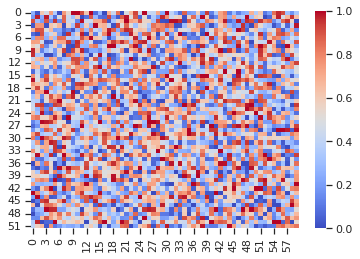

In [91]:
weights_heatmap(scaled_weights_enc, epoch=0,layer=0, normalize=True)

In [92]:
def interpolate_gif(weights_dict, block, layer):
    title_font = ImageFont.load_default()
    width = 256
    if np.min(weights_dict[i][layer].shape[:-1]) !=1:
        height = int((256/np.max(weights_dict[i][layer].shape[:-1]))*np.min(weights_dict[i][layer].shape[:-1]))
    else: 
        height=32
    images_list = [Image.fromarray((weights_dict[i][layer]*255).astype('uint8'), mode='RGB').resize((height, width)) for i in range(len(weights_dict))]
    draw_list = [ImageDraw.Draw(image).text((1,1), str(idx),font=title_font) for idx, image in enumerate(images_list)]
    images_list[0].save(gifs_path+
        f'{block}/layer_{layer}_shape_{weights_dict[i][layer].shape[:-1]}.gif',
        save_all=True,
        append_images=images_list[1:],
        duration = 16,
        loop=0)

In [ ]:
for i in range(20):
    interpolate_gif(colored_weights_dec, '/embedding_first/dec', i)